In [67]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import sys
import nltk
from nltk.corpus import stopwords
from gensim.models import ldamodel
import gensim.corpora
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import pickle
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import pyLDAvis.gensim
import warnings
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()
import numpy as np 
import pandas as pd
import string
import re
from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm
from collections import Counter,OrderedDict
from gensim import models,corpora
from gensim.summarization import summarize,keywords
import warnings
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.gensim
import gensim.models.phrases as gen
from gensim.models.coherencemodel import CoherenceModel

# Loading Data
Download Data from https://www.kaggle.com/hsankesara/medium-articles

In [68]:
data=pd.read_csv('/Users/anusha/Desktop/Projects/articles.csv')
len(data)

337

In [69]:
data.head(5)

,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


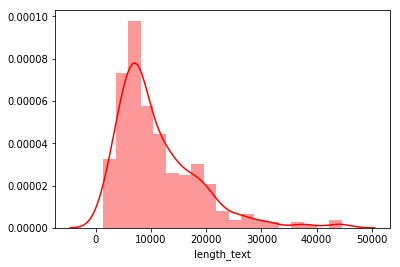

In [70]:
data['length_text'] = data['text'].str.len()
sns.distplot(data['length_text'], color="r")
plt.show()

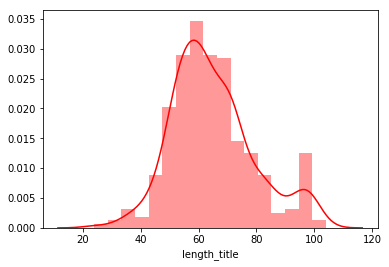

In [71]:
data['length_title'] = data['title'].str.len()
sns.distplot(data['length_title'], color="r")
plt.show()

In [110]:
titles = [x for x in data['title']]
docs = [x for x in data['text']]

In [111]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anusha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [112]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Data Preprocessing
We use NLTK’s Wordnet to find the meanings of words, synonyms, antonyms, and more. In addition, we use WordNetLemmatizer to get the root word. Filter out stop words.

In [192]:
# A function to prepare the text for topic modelling
def words(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    text = regex.sub(" ", text.lower())
    words = text.split(" ")
    words = [re.sub('\S*@\S*\s?', '', sent) for sent in words]
    words = [re.sub('\s+', ' ', sent) for sent in words]
    words = [re.sub("\'", "", sent) for sent in words]
    words = [w for w in words if not len(w) < 2]
    words = [w for w in words if w not in stop_words]
    words = [lmtzr.lemmatize(w) for w in words]
    
    return words

In [114]:
nltk.download('wordnet')
docs = [words(x) for x in data['text']]

[nltk_data] Downloading package wordnet to /Users/anusha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [115]:
 # Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words in initital documents: 18975
Number of unique words after removing rare and common words: 2720


In [148]:
corpus = [dictionary.doc2bow(doc) for doc in docs]
#print(len(corpus))
#corpus[336]
bow_doc_300 = corpus[300]

for i in range(len(bow_doc_300)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_300[i][0], 
                                                     dictionary[bow_doc_300[i][0]], 
                                                     bow_doc_300[i][1]))

Word 47 ("close") appears 1 time.
Word 51 ("command") appears 1 time.
Word 65 ("cool") appears 1 time.
Word 121 ("gate") appears 1 time.
Word 189 ("multi") appears 1 time.
Word 213 ("predicted") appears 1 time.
Word 247 ("scene") appears 1 time.
Word 281 ("terminal") appears 1 time.
Word 321 ("column") appears 6 time.
Word 339 ("excellent") appears 1 time.
Word 370 ("matrix") appears 1 time.
Word 431 ("www") appears 1 time.
Word 434 ("additional") appears 1 time.
Word 455 ("collection") appears 3 time.
Word 489 ("github") appears 1 time.
Word 503 ("irrelevant") appears 1 time.
Word 506 ("learning”") appears 1 time.
Word 535 ("ready") appears 1 time.
Word 538 ("relationship") appears 3 time.
Word 571 ("“deep") appears 1 time.
Word 579 ("andrew") appears 1 time.
Word 617 ("guess") appears 1 time.
Word 652 ("neuron") appears 4 time.
Word 736 ("comprehensive") appears 1 time.
Word 767 ("enables") appears 1 time.
Word 774 ("explanation") appears 1 time.
Word 777 ("faced") appears 1 time.
Wo

# Topic Modeling using LDA
LDA :: Latent Dirichlet Allocation is a probabilistic model. It is a unsupervised machine learning technique. And to obtain cluster assignments, it uses two probability values: P( word | topics) and P( topics | documents).

pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.

The size of the bubble measures the importance of the topics, relative to the data.
When we have 5 or 10 topics, we can see certain topics are clustered together (overlapping bubbles), this indicates the similarity between topics.

In [149]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [150]:
get_lda_topics(lda_model, 10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,neuron,star,cpu,de,cluster,bot,car,table,pixel,cnn
1,activation,review,house,member,agent,conversation,music,reward,woman,sheet
2,matrix,rating,gtx,sound,policy,behavior,graph,startup,men,box
3,zero,average,sentence,title,host,social,batch,recognize,convolution,region
4,player,weighted,gpu,speech,response,simulation,vehicle,array,kernel,pixel
5,policy,university,sequence,et,lstm,apps,track,tutorial,facial,bounding
6,man,interview,app,en,noise,interface,driving,translation,channel,mask
7,sigmoid,engineering,card,watson,trust,cognitive,placeholder,phrase,filter,proposal
8,derivative,programming,gpus,feed,reinforcement,response,song,distance,edge,segmentation
9,alphago,assignment,letter,netflix,unit,chatbots,computation,convolution,orientation,www


In [117]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [118]:
pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [119]:
pyLDAvis.gensim.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.083547 -0.027386       1        1  14.124918
2      0.001110  0.121423       2        1  13.309058
9     -0.003215  0.050101       3        1  12.913648
1      0.076798 -0.145448       4        1  12.042169
6      0.042512 -0.015228       5        1  11.228287
4      0.061736  0.093205       6        1  10.069935
8      0.028200  0.108357       7        1   8.781598
0      0.069313  0.038748       8        1   8.402618
5     -0.357725 -0.005984       9        1   5.084514
7     -0.002276 -0.217789      10        1   4.043257, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
734   Default  439.000000             cnn  439.000000  30.0000  30.0000
601   Default  315.000000              de  315.000000  29.0000  29.0000
1862  Default  228.000000            star  228.000000  28.0000  28.0000
397   Default  225.000000          review  225.000000  27.0000  27.0000
2025  Default  188.000000          rating  188.000000  26.0000  26.0000
20    Default  252.000000         average  252.000000  25.0000  25.0000
1041  Default  159.000000        weighted  159.000000  24.0000  24.0000
370   Default  266.000000          matrix  266.000000  23.0000  23.0000
1524  Default  195.000000           house  195.000000  22.0000  22.0000
652   Default  380.000000          neuron  380.000000  21.0000  21.0000
823   Default  229.000000          policy  229.000000  20.0000  20.0000
28    Default  299.000000             bot  299.000000  19.0000  19.0000
29    Default  299.000000             box  299.000000  18.0000  18.0000
1461  Default  182.000000      university  182.000000  17.0000  17.0000
2434  Default  166.000000          region  166.000000  16.0000  16.0000
1413  Default  170.000000             cpu  170.000000  15.0000  15.0000
420   Default  217.000000           table  217.000000  14.0000  14.0000
2218  Default  151.000000          member  151.000000  13.0000  13.0000
716   Default  195.000000           agent  195.000000  12.0000  12.0000
846   Default  210.000000        sequence  210.000000  11.0000  11.0000
840   Default  156.000000          reward  156.000000  10.0000  10.0000
1454  Default  160.000000           sheet  160.000000   9.0000   9.0000
1714  Default  139.000000             gtx  139.000000   8.0000   8.0000
661   Default  176.000000          player  176.000000   7.0000   7.0000
1062  Default  134.000000         cluster  134.000000   6.0000   6.0000
10    Default  211.000000             app  211.000000   5.0000   5.0000
998   Default  298.000000           pixel  298.000000   4.0000   4.0000
1539  Default  131.000000          letter  131.000000   3.0000   3.0000
1091  Default  194.000000           price  194.000000   2.0000   2.0000
2534  Default  115.000000              et  115.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
1665  Topic10    9.451900    neighborhood   22.358192   2.3471  -6.1995
2645  Topic10    5.204896        topology   12.550125   2.3280  -6.7961
2267  Topic10    5.589221        suitable   13.527190   2.3243  -6.7249
2132  Topic10    5.604738        pressing   13.663456   2.3170  -6.7221
999   Topic10   37.046745         pooling   90.849182   2.3111  -4.8336
1195  Topic10    5.867417       semantics   14.608694   2.2959  -6.6763
533   Topic10    8.943289       principal   22.422596   2.2890  -6.2548
971   Topic10   31.603983        internal   81.561165   2.2600  -4.9925
645   Topic10   30.869556            math   82.389801   2.2264  -5.0160
695   Topic10   30.142464           teach   82.981155   2.1954  -5.0398
1713  Topic10   19.103386         graphic   53.465294   2.1790  -5.4959
1422  Topic10   35.763916           drive  110.231407   2.0825  -4.8688
314   Topic10   45.028625        analysis  147.930969   2.0187  -4.63

The above is the visual representation of the topic modelling and the below is the raw representation and we can specify #words with highest probability to display in each topic. 

In [120]:
lda_model.save('model10.gensim')
topics = lda_model.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.019*"neuron" + 0.010*"activation" + 0.009*"matrix" + 0.008*"zero" + 0.008*"player" + 0.008*"policy"')
(1, '0.017*"star" + 0.015*"review" + 0.012*"rating" + 0.011*"average" + 0.010*"weighted" + 0.010*"university"')
(2, '0.010*"cpu" + 0.010*"house" + 0.009*"gtx" + 0.009*"sentence" + 0.009*"gpu" + 0.008*"sequence"')
(3, '0.034*"de" + 0.014*"member" + 0.012*"sound" + 0.011*"title" + 0.009*"speech" + 0.009*"et"')
(4, '0.014*"cluster" + 0.012*"agent" + 0.008*"policy" + 0.007*"host" + 0.007*"response" + 0.007*"lstm"')
(5, '0.011*"bot" + 0.006*"conversation" + 0.005*"behavior" + 0.005*"social" + 0.005*"simulation" + 0.004*"apps"')
(6, '0.011*"car" + 0.010*"music" + 0.008*"graph" + 0.008*"batch" + 0.007*"vehicle" + 0.006*"track"')
(7, '0.023*"table" + 0.009*"reward" + 0.008*"startup" + 0.007*"recognize" + 0.007*"array" + 0.006*"tutorial"')
(8, '0.020*"pixel" + 0.018*"woman" + 0.016*"men" + 0.015*"convolution" + 0.015*"kernel" + 0.011*"facial"')
(9, '0.095*"cnn" + 0.035*"sheet" + 0.035*"b

In [ ]:
#Performance evaluation by classifying sample document using LDA Bag of Words model
for index, score in sorted(lda_model[corpus[300]], key=lambda tup: -1*tup[1]) :
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 40)))

# Topic Modeling using NMF

In [158]:
data_text = data[['text']]
data_text = data_text.astype('str')

In [191]:
articles = [value[0] for value in data_text.iloc[0:].values]

In [161]:
articles_sentences = [' '.join(text) for text in articles]

In [162]:
# obtain a Counts design matrix
vectorizer = CountVectorizer(analyzer='word', max_features=1000);
x_counts = vectorizer.fit_transform(articles_sentences);

In [163]:
# set a TfIdf transformer, and transfer the counts with the model.
transformer = TfidfTransformer()
x_tfidf = transformer.fit_transform(x_counts);

In [164]:
#normalize the TfIdf values
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [166]:
num_topics = 10
model = NMF(n_components=num_topics, init='nndsvd');
model.fit(xtfidf_norm)

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
  max_iter=200, n_components=10, random_state=None, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [173]:
## Get words from each topic 
def get_nmf_topics(model, n_top_words):
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    word_dict = {};
    for i in range(num_topics):
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        words = [re.sub('\S*@\S*\s?', '', sent) for sent in words]
        words = [re.sub('\s+', ' ', sent) for sent in words]
        words = [re.sub("\'", "", sent) for sent in words]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    return pd.DataFrame(word_dict);

In [188]:
get_nmf_topics(model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,you,feature,policy,you,bot,you,you,you,you,you
1,ml,features,learning,functions,the,good,good,good,good,good
2,learning,featuretools,learn,list,bots,happening,happening,happening,happening,happening
3,machine,data,actions,function,it,hand,hand,hand,hand,hand
4,course,primitives,deep,data,chatbots,guis,guis,guis,guis,guis
5,even,table,value,if,and,growthbot,growthbot,growthbot,growthbot,growthbot
6,get,tables,the,python,apps,growth,growth,growth,growth,growth
7,if,the,this,numpy,re,group,group,group,group,group
8,re,client,state,lambda,human,greedy,greedy,greedy,greedy,greedy
9,world,engineering,rl,one,way,great,great,great,great,great


# Cosine Similarity b/w Documents
Given a keyword, Document Recommender system can suggest you the best documents from the pool of documents. 

In [175]:
words_list=list(chain.from_iterable(docs))

In [176]:
# Cosine similarity
def cosine_sim(text1, text2):
    tfidf_score = TfidfVectorizer().fit_transform([text1, text2])
    return ((tfidf_score * tfidf_score.T).A)[0, 1]

# Most similar article
def closest_doc_name(sentence, docs):
    cos = []
    for i in range(len(docs)):
        cos.append(cosine_sim(', '.join(sentence.split(' ')),', '.join(docs[i])))
    return [titles[x] for x in np.argsort(cos)[-10:][::-1]]

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=words, stop_words=stop_words).fit(words_list)

In [196]:
closest_doc_name('news', docs)

['How Artificial Intelligence can improve online news',
 'The 7 Best Data Science and Machine Learning Podcasts',
 'The Rise of the Weaponized AI Propaganda Machine – Scout: Science Fiction + Journalism – Medium',
 'The Rise of the Weaponized AI Propaganda Machine – Scout: Science Fiction + Journalism – Medium',
 'AI is coming, and it will be boring – Denny Vrandečić – Medium',
 'ИИ-психопат и ИИ-обманщик – Hey Machine Learning',
 'Turn your Raspberry Pi into homemade Google Home – Becoming Human: Artificial Intelligence Magazine',
 'What worries me about AI – François Chollet – Medium',
 'Announcing Poncho the WeatherBot – Render-from-betaworks',
 'Investing in Artificial Intelligence – Nathan Benaich – Medium']

# References
https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

https://medium.com/ml2vec/topic-modeling-is-an-unsupervised-learning-approach-to-clustering-documents-to-discover-topics-fdfbf30e27df